# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources: 
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html 

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details: 
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [23]:
import numpy as np

class GMM:
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter

    def initialize_params(self, X):
        # Randomly initialize the means, covariances, and mixing coefficients
        n_samples, n_features = X.shape
        self.weights = np.full(self.n_components, 1 / self.n_components)
        random_row = np.random.randint(low=0, high=n_samples, size=self.n_components)
        self.means = X[random_row, :]
        self.covars = [np.cov(X.T) for _ in range(self.n_components)]

    def multivariate_gaussian_pdf(self, x, mean, covar):
        n_features = x.shape[0]
        det_covar = np.linalg.det(covar)
        if det_covar == 0:
            covar += 1e-6 * np.eye(covar.shape[0])  # Add small positive value to diagonal
            det_covar = np.linalg.det(covar)
        inv_covar = np.linalg.inv(covar)
        exponent = -0.5 * np.dot(np.dot((x - mean).T, inv_covar), (x - mean))
        pdf = (1.0 / ((2 * np.pi) ** (n_features / 2) * np.sqrt(det_covar))) * np.exp(exponent)
        return pdf


    def E_step(self, X):
        n_samples = X.shape[0]
        self.responsibilities = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            for i in range(n_samples):
                self.responsibilities[i, k] = self.weights[k] * self.multivariate_gaussian_pdf(X[i], self.means[k], self.covars[k])
        self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)

    def M_step(self, X):
        n_samples = X.shape[0]
        for k in range(self.n_components):
            responsibility = self.responsibilities[:, k].sum()
            self.means[k] = (1 / responsibility) * np.dot(self.responsibilities[:, k].T, X)
            diff = X - self.means[k]
            self.covars[k] = np.dot((self.responsibilities[:, k] * diff.T), diff) / responsibility
            self.weights[k] = responsibility / n_samples

    def fit(self, X, y=None):
        self.initialize_params(X)
        for _ in range(self.max_iter):
            prev_means = self.means.copy()
            self.E_step(X)
            self.M_step(X)
            if np.linalg.norm(self.means - prev_means) < self.tol:
                break

    def predict(self, X):
        self.E_step(X)  # Update responsibilities
        return np.argmax(self.responsibilities, axis=1)

    def predict_proba(self, X):
        self.E_step(X)  # Update responsibilities
        return self.responsibilities

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

In [4]:
import os
print(os.path.abspath("Q2.ipybn"))

E:\Ayush\rollnumber_A2\rollnumber_A2\rollnumber_A2_Q2\Q2.ipybn


#### Extracting Frames from videos

In [1]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [2]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [3]:
print(frames_path)

./frames/traffic


In [4]:
!mkdir -p ./frames/traffic


The syntax of the command is incorrect.


In [5]:
import os

# Create the directory if it doesn't exist
os.makedirs(frames_path, exist_ok=True)

In [6]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [7]:
%%capture

!ffmpeg -i {source_path} {frames_path}/frame_%04d.png


#### Loading Frames

In [11]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [12]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps) 
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

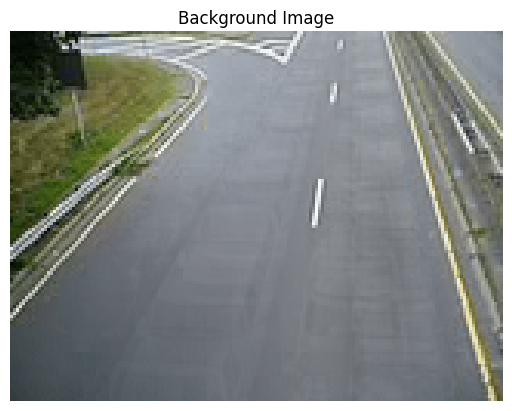

In [13]:


# Compute the average of all frames in the training set
background_image = np.mean(train_frames, axis=0)

# Display the background image
plt.imshow(background_image)
plt.axis('off')
plt.title('Background Image')
plt.show()


#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [30]:
def create_pixel_gmms(train_frames, n_components=2, tol=1e-3, max_iter=100):
    n_frames, height, width, channels = train_frames.shape
    pixel_gmms = np.empty((height, width), dtype=object)
    
    for i in range(height):
        for j in range(width):
            pixel_data = train_frames[:, i, j, :]  # Extract pixel data across all frames
            gmm = GMM(n_components=n_components, tol=tol, max_iter=max_iter)
            gmm.fit(pixel_data)
            pixel_gmms[i, j] = gmm
    
    return pixel_gmms


In [31]:
pixel_gmms = fit_gmm_per_pixel(train_frames)

C:\Users\suraj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


#### Extract Background Image from the trained model

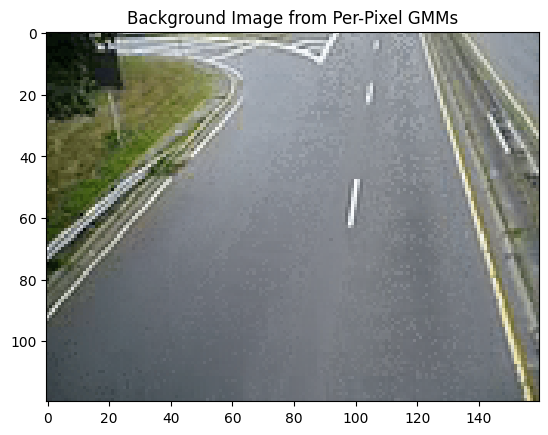

In [33]:
def extract_background_gmm(gmm_models):
    height, width = gmm_models.shape
    background_image = np.zeros((height, width, 3))

    for i in range(height):
        for j in range(width):
            gmm = gmm_models[i, j]
            # Assume the Gaussian with the highest weight corresponds to the background
            background_index = np.argmax(gmm.weights_)
            background_image[i, j, :] = gmm.means_[background_index]

    return background_image

background_image_gmm = extract_background_gmm(pixel_gmms)

# Display the GMM-based background image
plt.imshow(background_image_gmm)
plt.title("Background Image from Per-Pixel GMMs")
plt.show()

C:\Users\suraj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [38]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001
    
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
        
        vid_wrt.write(frame)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

In [34]:
display_frames([background_image])

In [35]:
save_frames([background_image], output_path='./results', file_name='background')

#### Frame Averaging

In [39]:
# compute the background image using Frame Averaging
background_image = np.mean(train_frames, axis=0)

# subtract the background image from each test frame to get the foreground
foreground_frames = [np.abs(frame - background_image) for frame in test_frames]

# apply thresholding to highlight significant foreground objects
thresholded_frames = [np.where(frame > 0.2, 1, 0) for frame in foreground_frames]  


save_frames(thresholded_frames, fps=10.0, output_path='./results', file_name='foreground_video')


In [ ]:
def subtract_background_gmm(test_frames, gmm_models):
    n_frames, height, width, channels = test_frames.shape
    foreground_frames = np.zeros_like(test_frames)

    for i in range(height):
        for j in range(width):
            for k in range(n_frames):
                pixel_value = test_frames[k, i, j, :].reshape(1, -1)
                gmm = gmm_models[i, j]
                # Predict the component label for each pixel value
                label = gmm.predict(pixel_value)[0]
                # Assuming the component with the highest weight is background, label=0
                if label != 0:  # Foreground
                    foreground_frames[k, i, j, :] = test_frames[k, i, j, :]
    return foreground_frames


#### GMMs per pixel

In [41]:
def subtract_background_gmm(test_frames, pixel_gmms):
    n_frames, height, width, channels = test_frames.shape
    foreground_frames = np.zeros_like(test_frames)

    for i in range(height):
        for j in range(width):
            for k in range(n_frames):
                pixel_value = test_frames[k, i, j, :].reshape(1, -1)
                gmm = pixel_gmms[i, j]
                # Predict the component label for each pixel value
                label = gmm.predict(pixel_value)[0]
                # Assuming the component with the highest weight is background, label=0
                if label != 0:  # Foreground
                    foreground_frames[k, i, j, :] = test_frames[k, i, j, :]
    return foreground_frames

# subtracting the background using fitted GMMs on test frames
foreground_frames_gmm = subtract_background_gmm(test_frames, pixel_gmms)





In [45]:
display_frames([foreground_frames_gmm])

In [46]:
save_frames([foreground_frames_gmm], output_path='./results', file_name='background')